In [1]:
import os
import json
import yaml
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatch
import matplotlib
%matplotlib inline

from results_plotter import read_exp_results as read_exp

In [3]:
def get_im_vol_list(target_volunteers, num_images):
    im_vol_list = []
    for i in range(num_images):
        x = target_volunteers[target_volunteers[:,0] == i, -1].int().detach().numpy()
        num_boxes = x.shape[0]
        vol_per_im = []
        for j in range(num_boxes):
            vol_per_im.append(x[j])
        im_vol_list.append(vol_per_im)
    return im_vol_list

In [4]:
# rel_path = os.path.join(os.curdir, 'runs', 'train')
rel_path = os.path.join('/Users/gs0029/onedrive/University of Surrey/Yin, Camellia (PG R - Computer Science) - runs', 'train')

In [5]:
metadata_filename = 'results_metadata.json'
metadata = json.load(open(metadata_filename, 'r'))
metadata

{'baseline': {'name': 'yolo', 'exp_id': 218},
 'contribution': {'name': 'cyolo', 'exp_id': 236}}

In [6]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
exp_results.keys()

dict_keys(['results', 'hyp', 'opt', 'pred', 'cm'])

In [7]:
data_yaml_filename = exp_results['opt']['data']
data_dict = yaml.safe_load(open(data_yaml_filename, 'r'))
data_path = data_dict['path']
train_path = os.path.join(data_path, data_dict['train'])
val_path = os.path.join(data_path, data_dict['val'])
test_path = os.path.join(data_path, data_dict['test'])
data_dict

{'path': 'datasets',
 'train': 'iid-tvt/images/train',
 'val': 'iid-tvt/images/val',
 'test': 'iid-tvt/images/test',
 'nc': 2,
 'names': ['bone-loss', 'dental-caries']}

In [113]:
im_name = yolo_im_names[0]
im_name

'IS20191125_105634_0062_000039C9.Camellia'

In [8]:
class_names = data_dict['names']
class_name_abbr_map = {'bone-loss': 'BL', 'dental-caries': 'DC'}

In [78]:
def get_im_boxes_map(preds):
    im_boxes_map = defaultdict(list)
    for pred in tqdm(preds):
        im_id = pred['image_id']
        im_boxes_map[im_id].append({k:v for k, v in pred.items() if k != 'image_id'})
    im_boxes_map = dict(im_boxes_map)
    im_names = list(sorted(im_boxes_map))
    return im_boxes_map, im_names

In [79]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
yolo_preds = exp_results['pred']
yolo_im_boxes_map, yolo_im_names = get_im_boxes_map(yolo_preds)

  0%|          | 0/21996 [00:00<?, ?it/s]

In [80]:
exp_no = metadata['contribution']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
cyolo_preds = exp_results['pred']
cyolo_im_boxes_map, cyolo_im_names = get_im_boxes_map(cyolo_preds)

  0%|          | 0/24000 [00:00<?, ?it/s]

In [107]:
exp_results.keys()

dict_keys(['results', 'hyp', 'opt', 'pred', 'cm'])

In [81]:
def get_im_boxes(im_name, mode):
    if mode == 'y':
        return yolo_im_boxes_map[im_name]
    elif mode == 'cy':
        return cyolo_im_boxes_map[im_name]
    elif mode == 'v':
        return yolo_im_boxes_map[im_name]
    elif mode == 'e':
        return yolo_im_boxes_map[im_name]

In [82]:
def plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres):
    img = mpimg.imread(im_filepath)

    ax.axis('off')
    img_plot = ax.imshow(img)

    box_linewidth = 2
    box_color_map = {'bone-loss': 'r', 'dental-caries': 'y'}
    use_abbr_labels = True
    text_on_box_color = 'w'
    text_on_box_fontsize = 10
    text_on_box_ha = 'left'
    text_on_box_va = 'center'

    for im_box in im_boxes:
        box_class = im_box['category_id']
        bbox = im_box['bbox']
        box_score = im_box['score']
        text_on_box = class_names[box_class]
        if box_score < conf_thres[text_on_box]:
            continue
        box_color = box_color_map[text_on_box]
        if use_abbr_labels:
            text_on_box = class_name_abbr_map[text_on_box]
        text_on_box = f'{text_on_box} ({int(box_score*100)}%)'
        x, y, w, h = bbox
        box = mpatch.Rectangle((x, y), w, h, linewidth=box_linewidth, edgecolor=box_color, facecolor='none')
        ax.add_artist(box)
        _ = ax.annotate(text_on_box, (x+w, y-text_on_box_fontsize),
                        backgroundcolor=box_color,
                        color=text_on_box_color, weight='bold', 
                        fontsize=text_on_box_fontsize,
                        ha=text_on_box_ha,
                        va=text_on_box_va)

In [104]:
# scale_per_image = 10
scale = 15

radiographs_toplot_list = []
modes = ['v', 'e', 'y', 'cy']
mode_names = {'v': 'Volunteers',
              'e': 'Expert',
              'y': 'YOLO',
              'cy': 'CYOLO'}
im_ids = [0, 10, 20, 30]

for mode in modes:
    list_per_mode = []
    for im_id in im_ids:
        im_name = im_names[im_id]
        im_filename = f'{im_name}.jpg'
        im_filepath = os.path.join(val_path, im_filename)
        im_boxes = get_im_boxes(im_name, mode)
        list_per_mode.append((im_filepath, im_boxes))
    radiographs_toplot_list.append(list_per_mode)

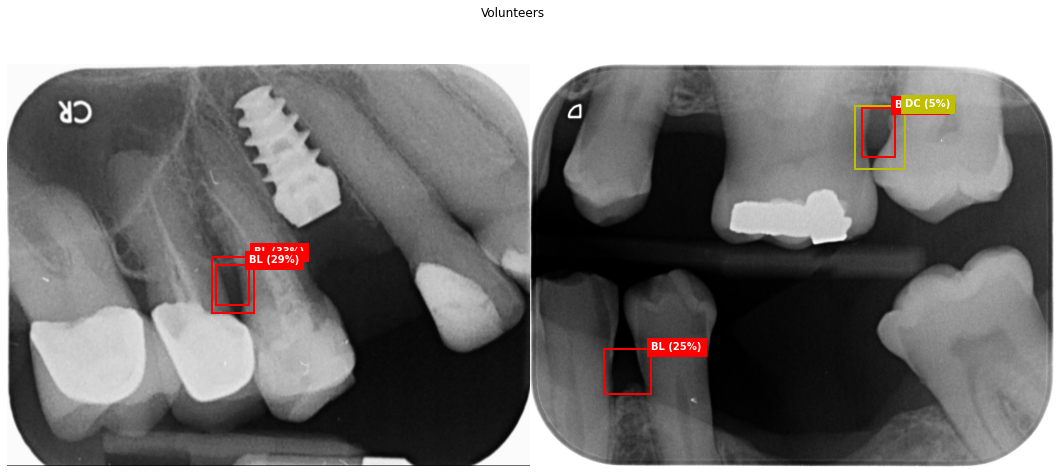

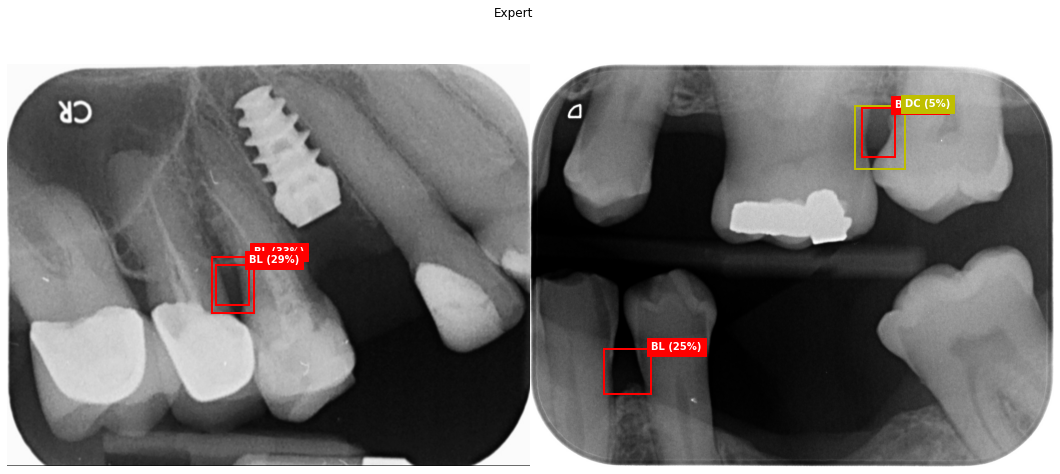

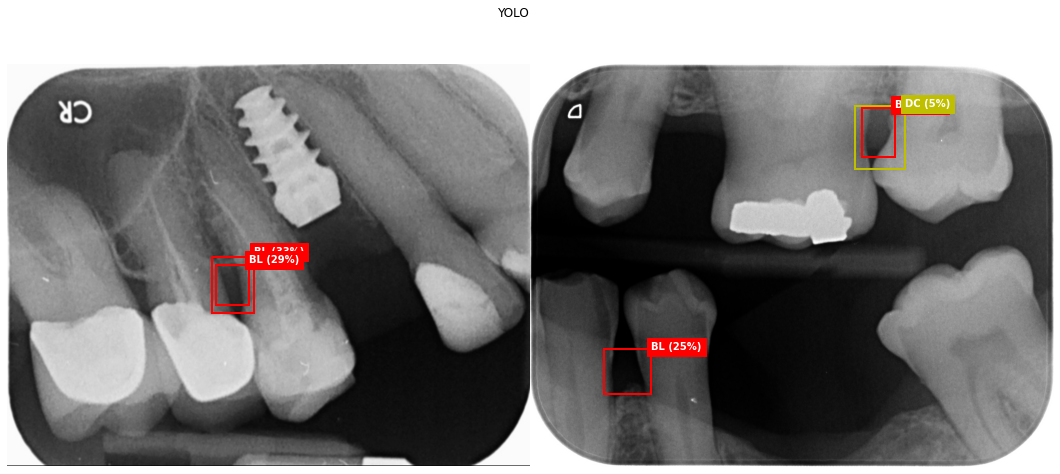

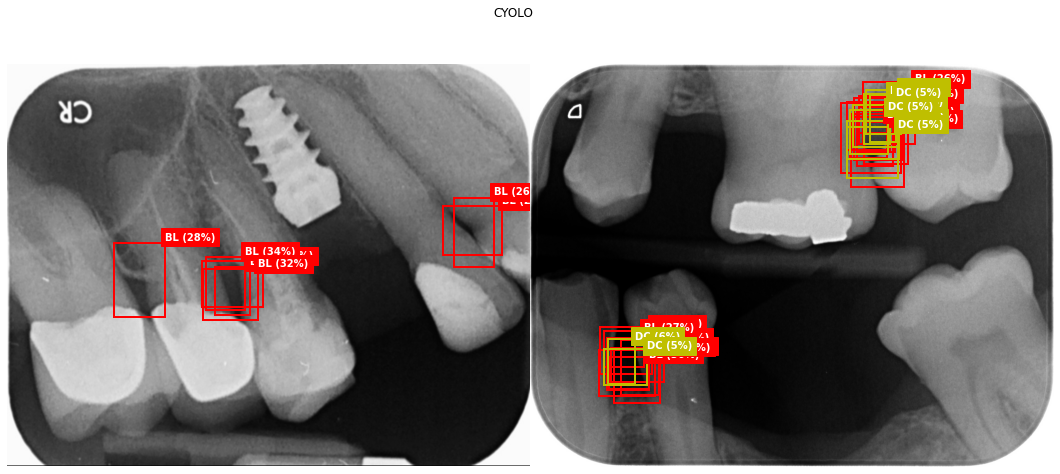

In [117]:
inner_grid = (1, 2)
conf_thres = {'bone-loss': 0.25, 'dental-caries': 0.05}

for m, mode in enumerate(modes):
    fig, axs = plt.subplots(*inner_grid, figsize=(1.25*scale, scale/2))
    # subfigs = fig.subfigures(*outer_grid)
    fig.suptitle(f'{mode_names[mode]}')
    fig.subplots_adjust(wspace=0, hspace=0)
    for innerind, ax in enumerate(axs.flat):
        im_filepath, im_boxes = radiographs_toplot_list[m][innerind]
        plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres)

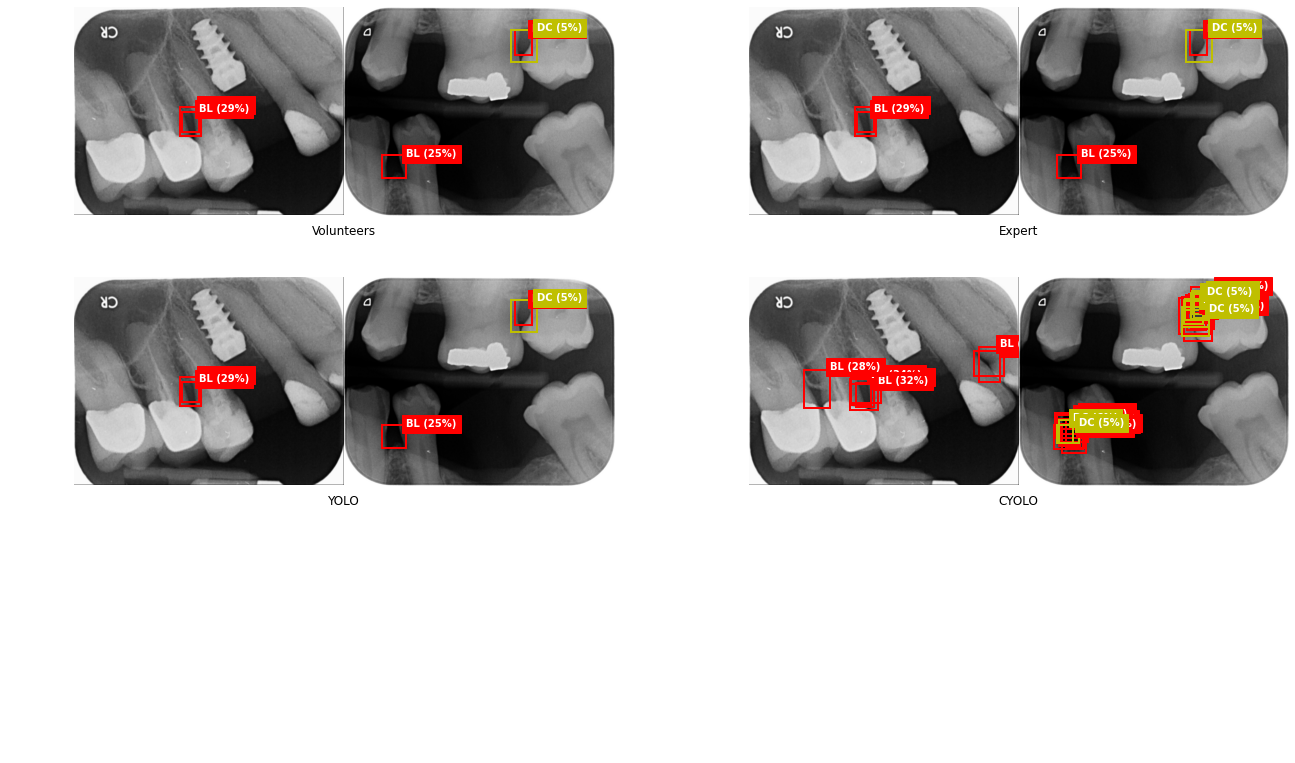

In [105]:
outer_grid = (2, 2)
inner_grid = (1, 2)
conf_thres = {'bone-loss': 0.25, 'dental-caries': 0.05}

fig = plt.figure(constrained_layout=False, figsize=(1.25*scale, scale/2))

subfigs = fig.subfigures(*outer_grid)
fig.subplots_adjust(wspace=0, hspace=0)
for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'{mode_names[modes[outerind]]}')
    axs = subfig.subplots(*inner_grid)
    subfig.subplots_adjust(wspace=0, hspace=0)
    for innerind, ax in enumerate(axs.flat):
        im_filepath, im_boxes = radiographs_toplot_list[outerind][innerind]
        plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres)

fig.subplots_adjust(left=0.1, right=0.9, top=2.7, bottom=0.1)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2, 2)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Subfig {outerind}')
    axs = subfig.subplots(2, 1)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(f'outer={outerind}, inner={innerind}', fontsize='small')
        ax.set_xticks([])
        ax.set_yticks([])
 
plt.show()
